In [1]:
import os
import sys
from  study_alignment.utils import get_dropbox_dir
import pandas as pd
import numpy as np
import json
import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

from ml.prep import SimpleDataset

In [2]:

dropbox_dir = get_dropbox_dir()
base_dir = os.path.join(dropbox_dir, 'development_CohortCombination','alignment_RCC_2024_Feb_27')
data_dir = os.path.join(base_dir, 'alignment_id_29', 'merge_reference_freq_th_0.4_freq_th_0.1')
rcc_metadata_file = os.path.join(dropbox_dir, 'development_CohortCombination','clean_rcc_metadata.csv')

desc_str = 'temp'

In [3]:
rcc_metadata = pd.read_csv(rcc_metadata_file, index_col=0)

In [4]:
metadata = pd.read_csv(os.path.join(data_dir, 'subset_metadata.csv'), index_col=0)

In [10]:
# Join the two metadata together
metadata = metadata.join(rcc_metadata, how='outer')
metadata.to_csv(os.path.join(data_dir, 'subset_metadata_with_rcc.csv'))

In [ ]:
data_corrected = pd.read_csv(os.path.join(data_dir, 'subset_data_corrected.csv'), index_col=0)
nan_mask = pd.read_csv(os.path.join(data_dir, 'subset_nan_mask.csv'), index_col=0)

In [46]:
# Choose to look at only a subset of the data

subset_metadata = metadata[metadata['Cohort Label'].isin(['adult_cancer','adult_other'])].copy()
subset_nan_mask = nan_mask[subset_metadata.index]

# successively remove the worst samples and features based on the nan_mask
for thresh in [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6]:
    subset_nan_mask = subset_nan_mask[subset_metadata.index]
    good_samples = subset_nan_mask.sum(axis=0) < subset_nan_mask.shape[0]*thresh
    subset_nan_mask = subset_nan_mask[good_samples[good_samples].index]
    good_features = subset_nan_mask.sum(axis=1) < subset_nan_mask.shape[1]*thresh
    subset_nan_mask = subset_nan_mask.loc[good_features[good_features].index]
    subset_metadata = subset_metadata.loc[subset_nan_mask.columns]
    print(subset_nan_mask.shape)


(3293, 7144)
(3290, 7142)
(3216, 7013)
(3003, 6568)
(2710, 6277)
(2413, 6238)
(2088, 6190)
(1808, 6162)


In [57]:
# Assign the new subsets to overwrite the original data
if True:
    subset_dir = os.path.join(data_dir, 'subset_'+desc_str)
    os.mkdir(subset_dir)

    data_corrected = data_corrected.loc[subset_nan_mask.index, subset_nan_mask.columns]
    nan_mask = nan_mask.loc[subset_nan_mask.index, subset_nan_mask.columns]
    metadata = metadata.loc[subset_nan_mask.columns]
    print(metadata.shape, data_corrected.shape, nan_mask.shape)


    # remove the features with zero variance
    # good_features2 = data_corrected.var(axis=1) > 0
    # good_features2= good_features2[good_features2].index
    # data_corrected = data_corrected.loc[good_features2]
    # nan_mask = nan_mask.loc[good_features2]
    # print(metadata.shape, data_corrected.shape, nan_mask.shape)

    (data_corrected.T).to_csv(os.path.join(subset_dir, 'X.csv'))
    metadata.to_csv(os.path.join(subset_dir, 'y.csv'))
    (nan_mask.T).to_csv(os.path.join(subset_dir, 'nans.csv'))

In [53]:
rcc3_baseline = rcc_metadata[
    (rcc_metadata['study_week']=='baseline') &
    (rcc_metadata['phase']=='RCC3')
]

rcc1_baseline = rcc_metadata[
    (rcc_metadata['study_week']=='baseline') &
    (rcc_metadata['phase']=='RCC1')
]


# all other files go to the pretraining group
other_files = metadata.index.difference(rcc3_baseline.index).difference(rcc1_baseline.index)

# we could include the the rcc3 baseline files in the pretraining group, since we are not using their metadata during pretraining
all_files = metadata.index.to_list()
pretrain_only_files = other_files.to_list()
finetune_files = rcc3_baseline.index.to_list()
holdout_files = rcc1_baseline.index.to_list()

## Stratified Split the Pretraining data

In [41]:
rskf_params = {
        'n_splits': 5,
        'n_repeats': 2,
        'random_state': 42,
    }
stratify_col = 'Cohort ID Expanded'

save_dir = os.path.join(data_dir, f'{desc_str}_pretrain_folds')
os.makedirs(save_dir, exist_ok=True)


In [42]:
rskf = RepeatedStratifiedKFold(**rskf_params)

rskf_list = []

for i, (train_idx, test_idx) in enumerate(rskf.split(metadata.index, metadata[stratify_col])):
    train_files = metadata.index[train_idx]
    test_files = metadata.index[test_idx]

    test_bool = np.zeros(len(metadata), dtype=bool)
    test_bool[test_idx] = True
    rskf_list.append(test_bool)

rskf_df = pd.DataFrame(index=metadata.index)
for i, test_idx in enumerate(rskf_list):
    rskf_df[f'fold_{i}'] = test_idx

rskf_df.to_csv(os.path.join(save_dir, 'splits.csv'))

rskf_info = {
    'rskf_params': rskf_params,
    'stratify_col': stratify_col,
    'desc_str': desc_str,
    'size': rskf_df.shape[0],
    'Train Bool' : False,
    'Test Bool' : True,
}

with open(os.path.join(save_dir, 'splits_info.json'), 'w') as f:
    json.dump(rskf_info, f, indent=4)



# X = data_corrected[rskf_df.index].T
# y = metadata.loc[rskf_df.index]
# nans = nan_mask[rskf_df.index].T.astype(bool)

# X.to_csv(os.path.join(save_dir, 'X.csv'))
# y.to_csv(os.path.join(save_dir, 'y.csv'))
# nans.to_csv(os.path.join(save_dir, 'nans.csv'))



## Stratified Split the Finetune data

In [54]:
rskf_params = {
        'n_splits': 5,
        'n_repeats': 1,
        'random_state': 42,
    }

metadata_subset = rcc3_baseline.copy()

stratify_cols =['MSKCC','Treatment','Benefit']

stratify_col = 'multiple_categories'
metadata_subset[stratify_col] = metadata_subset[stratify_cols].apply(lambda x: '_'.join(x), axis=1)

save_dir = os.path.join(data_dir, f'{desc_str}_finetune_folds')
os.makedirs(save_dir, exist_ok=True)

In [55]:
rskf = RepeatedStratifiedKFold(**rskf_params)

rskf_list = []

for i, (train_idx, test_idx) in enumerate(rskf.split(metadata_subset.index, metadata_subset[stratify_col])):
    train_files = metadata_subset.index[train_idx]
    test_files = metadata_subset.index[test_idx]

    test_bool = np.zeros(len(metadata_subset), dtype=bool)
    test_bool[test_idx] = True
    rskf_list.append(test_bool)

rskf_df = pd.DataFrame(index=metadata_subset.index)
for i, test_idx in enumerate(rskf_list):
    rskf_df[f'fold_{i}'] = test_idx

rskf_df.to_csv(os.path.join(save_dir, 'splits.csv'))

rskf_info = {
    'rskf_params': rskf_params,
    'stratify_col': stratify_col,
    'desc_str': desc_str,
    'size': rskf_df.shape[0],
    'Train Bool' : False,
    'Test Bool' : True,
}

with open(os.path.join(save_dir, 'splits_info.json'), 'w') as f:
    json.dump(rskf_info, f, indent=4)



# X = data_corrected[rskf_df.index].T
# y = metadata.loc[rskf_df.index]
# nans = nan_mask[rskf_df.index].T.astype(bool)

# X.to_csv(os.path.join(save_dir, 'X.csv'))
# y.to_csv(os.path.join(save_dir, 'y.csv'))
# nans.to_csv(os.path.join(save_dir, 'nans.csv'))


## Run Classical Models on the desired tasks

In [56]:
from ml.sklearn_models import run_train_sklearn_model


In [63]:
save_dir = os.path.join(data_dir, f'{desc_str}_finetune_folds')

finetune_label_col = 'MSKCC'
finetune_label_mapper  = {'FAVORABLE': 1, 'POOR': 0, 'INTERMEDIATE': np.nan}

# finetune_label_col = 'Benefit'
# finetune_label_mapper  = {'CB': 1, 'NCB': 0, 'ICB': np.nan}

task_dir = os.path.join(save_dir, finetune_label_col)

splits_df = pd.read_csv(os.path.join(save_dir, 'splits.csv'), index_col=0)

X = data_corrected[splits_df.index].T
y = rcc_metadata.loc[splits_df.index]
nans = nan_mask[splits_df.index].T.astype(bool)

n_folds = splits_df.shape[1]
yes_dropna = True

task_info = {
    'label_col': finetune_label_col,
    'label_mapper': finetune_label_mapper,
    'desc_str': desc_str,
    'size': splits_df.shape[0],
    'size by label': y[finetune_label_col].map(finetune_label_mapper).value_counts().to_dict(),
    'folds': splits_df.shape[1],
    'dropna': yes_dropna,
}

os.makedirs(task_dir, exist_ok=True)
with open(os.path.join(task_dir, 'task_info.json'), 'w') as f:
    json.dump(task_info, f, indent=4)

In [66]:

output_dir = os.path.join(task_dir, 'classical_models')
os.makedirs(save_dir, exist_ok=True)


y_values = y[finetune_label_col].map(finetune_label_mapper)
if yes_dropna:
    print('dropping nan values in the y column')
    y_values = y_values.dropna()
    X = X.loc[y_values.index]
    splits_df = splits_df.loc[y_values.index]

for model_kind in ['logistic_regression', 'random_forest', 'svc']:
    gather_output = []
    model_name = model_kind + '_default'
    output_summary_file = os.path.join(output_dir, f'{model_name}_summary.csv')
    for subset_id in range(n_folds):



        train_idx = splits_df.index[splits_df[f'fold_{subset_id}'] == False]
        test_idx = splits_df.index[splits_df[f'fold_{subset_id}'] == True]
        finetune_dataset = SimpleDataset(X.loc[train_idx], y_values.loc[train_idx])
        
        class_weights = 1 / torch.bincount(finetune_dataset.y.long())

        test_dataset = SimpleDataset(X.loc[test_idx], y_values.loc[test_idx])

        data_dict = {'train': finetune_dataset, 'test': test_dataset}

        output_data = run_train_sklearn_model(data_dict,output_dir,
                                model_kind = model_kind,
                                model_name=f'{model_name}_{subset_id}',
                                # model_name=model_name,
                                param_grid={})
        

        gather_output.append(output_data)

    ## Summarize the important results
    # best_epoch_list = [output['best_epoch'] for output in gather_output]
    val_auroc_list = [output['end_state_auroc']['test'] for output in gather_output]
    train_auroc_list = [output['end_state_auroc']['train'] for output in gather_output]
    # model_name = gather_output[0]['model_name']
    auc_summary = pd.DataFrame({
                    'train_auroc': train_auroc_list,
                    'test_auroc': val_auroc_list,})


    result_summary_avg = auc_summary.mean()
    result_summary_std = auc_summary.std()
    result_summary_avg.index = [f'AVG {col}' for col in result_summary_avg.index]
    result_summary_std.index = [f'STD {col}' for col in result_summary_std.index]
    result_summary = pd.concat([result_summary_avg, result_summary_std])
    result_summary.to_csv(output_summary_file)

dropping nan values in the y column


<Axes: xlabel='file name'>

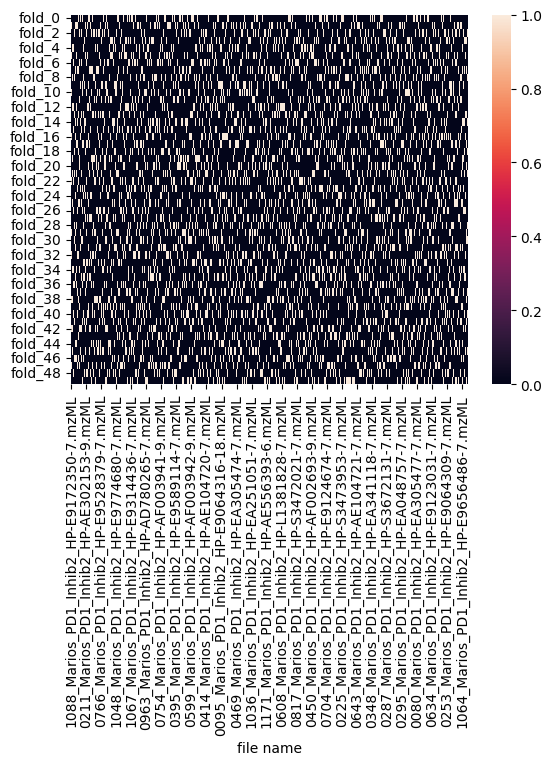

In [69]:
import seaborn as sns
sns.heatmap(splits_df.T)